In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!gdown --id 1ibjbccZPik-ramrZjYDVAXILJ6sna9g3

In [ ]:
!unzip /content/img_align_celeba.zip -d /content/celeba_data > /dev/null 2>&1

In [ ]:
transform = transforms.Compose([
    transforms.CenterCrop(140),
    transforms.Resize(64),
    transforms.ToTensor(),
])

data_path = "/content/celeba_data/"
dataset = ImageFolder(root=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

In [3]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, image_size=64):
        self.root_dir = root_dir
        self.image_files = sorted(os.listdir(root_dir))
        self.transform = transforms.Compose([
            transforms.CenterCrop(140),
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        return self.transform(image)

image_folder = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
dataset = CelebADataset(image_folder, image_size=64)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

images = next(iter(dataloader))
print("Sample batch shape:", images.shape)

Sample batch shape: torch.Size([64, 3, 64, 64])


In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.lrelu(self.fc1(x))
        h = self.lrelu(self.fc2(h))
        return self.fc_mean(h), self.fc_logvar(h)

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, z):
        h = self.lrelu(self.fc1(z))
        h = self.lrelu(self.fc2(h))
        x_hat = torch.sigmoid(self.fc_out(h))
        return x_hat.view(-1, 3, 64, 64)

In [6]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(device)
        return mean + eps * std

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [7]:
def loss_fn(x, x_hat, mean, log_var):
    x = x.view(x.size(0), -1)
    x_hat = x_hat.view(x_hat.size(0), -1)
    recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kld

In [8]:
input_dim = 3 * 64 * 64
hidden_dim = 512
latent_dim = 128

encoder = Encoder(input_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, input_dim)
model = VAE(encoder, decoder).to(device)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
start_epoch = 0
os.makedirs("checkpoints", exist_ok=True)

checkpoint_path = "checkpoints/last_checkpoint.pth"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resuming from epoch {start_epoch}")
else:
    print("Starting training from scratch.")

Resuming from epoch 20


In [20]:
num_epochs = 30
losses = []

for epoch in range(start_epoch, num_epochs):
    model.train()
    for batch in dataloader:
        x = batch.to(device)
        x_hat, mean, log_var = model(x)
        x_hat, mean, log_var = x_hat.to(device), mean.to(device), log_var.to(device)
        loss = loss_fn(x, x_hat, mean, log_var)

        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
    }, f"checkpoints/epoch_{epoch:02d}.pth")

    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
    }, "checkpoints/last_checkpoint.pth")

    avg_loss = sum(losses[-len(dataloader):]) / len(dataloader)
    print(f"Finished epoch {epoch}. Average loss: {avg_loss:.4f}")

Finished epoch 20. Average loss: 418955.8815
Finished epoch 21. Average loss: 418920.8268
Finished epoch 22. Average loss: 418862.2488
Finished epoch 23. Average loss: 418828.0091
Finished epoch 24. Average loss: 418796.1700
Finished epoch 25. Average loss: 418749.7742
Finished epoch 26. Average loss: 418719.9650
Finished epoch 27. Average loss: 418682.3506
Finished epoch 28. Average loss: 418664.8732
Finished epoch 29. Average loss: 418641.4994


In [21]:
with open("losses.txt", "w") as f:
    for l in losses:
        f.write(f"{l}\n")

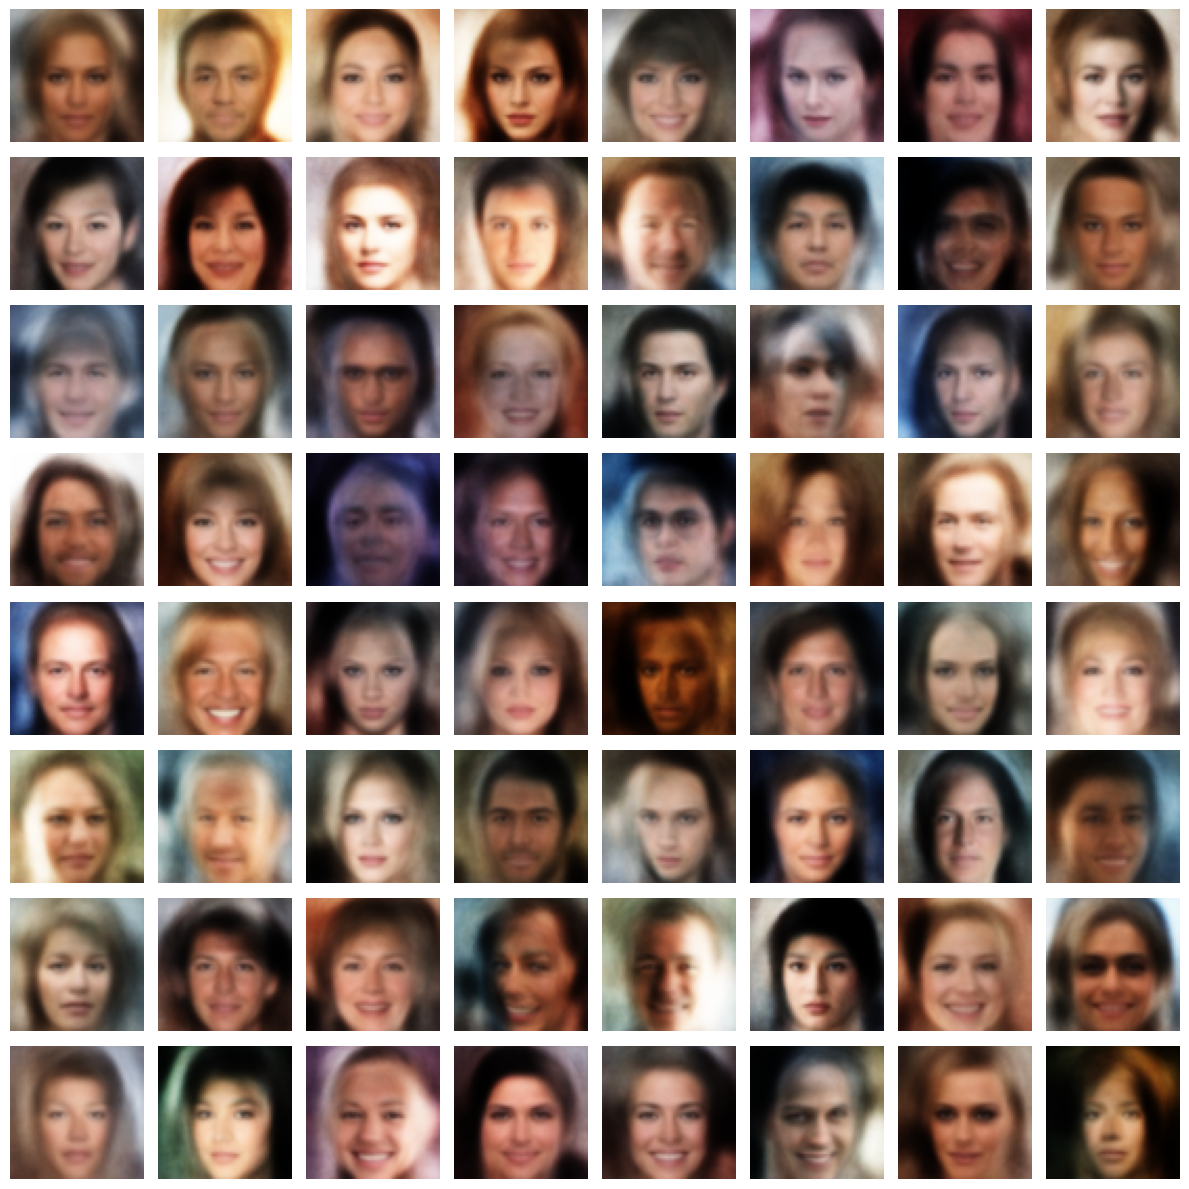

In [22]:
model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    samples = decoder(z)

grid = make_grid(samples, nrow=8, normalize=True)
save_image(grid, "generated_images.png")

fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i, img in enumerate(samples):
    row, col = divmod(i, 8)
    img_np = img.cpu().permute(1, 2, 0).numpy()
    axes[row, col].imshow(np.clip(img_np, 0, 1))
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

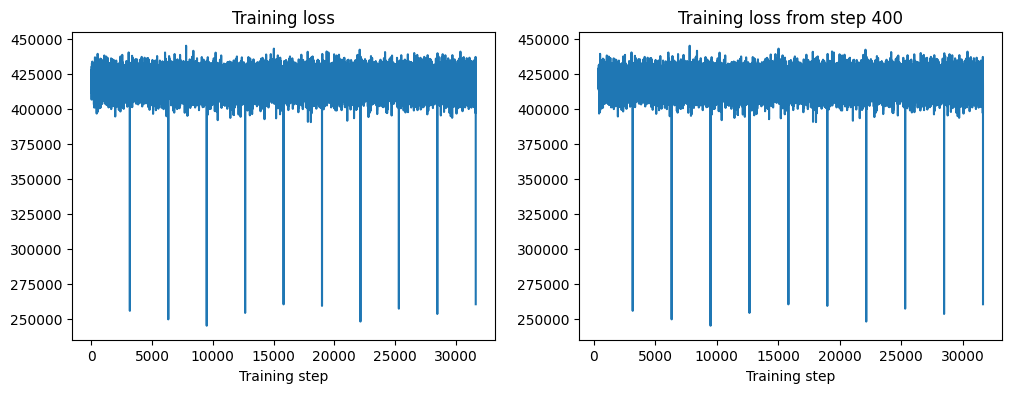

In [23]:
plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")

plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step")
plt.show()

In [24]:
print('jhdjsdh')

jhdjsdh


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import shutil

destination = '/content/drive/MyDrive/VAE/checkpoints'
shutil.copytree('/content/checkpoints', destination)

In [ ]:
!cp /content/generated_images.png /content/drive/MyDrive/VAE/
!cp /content/losses.txt /content/drive/MyDrive/VAE/